In [54]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf
import wandb_util.wandb_util as wbu
import multiprocessing as mp
mp.set_start_method('spawn', force=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
from wandb_util.wandb_util import ExperimentConfig


config = OmegaConf.load('config/experiments/gr_benchmark_big.yaml')
config = ExperimentConfig(**config)
config.exp_name = "benchmark_big_again"

config.sync_experiment()

Experiment: https://wandb.ai/romeu/diffusion-3D-features/groups/benchmark_big_again/workspace

Would execute 219 new runs:
- mv_helmetlatest_ShinyHelmet
- cat_statue_mvlatest_MetalicCatStatue
- GR-0
- GR-0
- GR-0
- GR-0
- GR-0
- GR-0
- GR-0
- GR-1
- GR-1
- GR-1
- GR-1
- GR-1
- GR-1
- GR-1
- GR-2
- GR-2
- GR-2
- GR-2
- GR-2
- GR-2
- GR-2
- GR-3
- GR-3
- GR-3
- GR-3
- GR-3
- GR-3
- GR-3
- GR-4
- GR-4
- GR-4
- GR-4
- GR-4
- GR-4
- GR-4
- GR-5
- GR-5
- GR-5
- GR-5
- GR-5
- GR-5
- GR-5
- GR-6
- GR-6
- GR-6
- GR-6
- GR-6
- GR-6
- GR-6
- GR-7
- GR-7
- GR-7
- GR-7
- GR-7
- GR-7
- GR-7
- GR-8
- GR-8
- GR-8
- GR-8
- GR-8
- GR-8
- GR-8
- GR-9
- GR-9
- GR-9
- GR-9
- GR-9
- GR-9
- GR-9
- GR-10
- GR-10
- GR-10
- GR-10
- GR-10
- GR-10
- GR-10
- GR-11
- GR-11
- GR-11
- GR-11
- GR-11
- GR-11
- GR-11
- GR-12
- GR-12
- GR-12
- GR-12
- GR-12
- GR-12
- GR-12
- GR-13
- GR-13
- GR-13
- GR-13
- GR-13
- GR-13
- GR-13
- GR-14
- GR-14
- GR-14
- GR-14
- GR-14
- GR-14
- GR-14
- GR-15
- GR-15
- GR-15
- GR-15
- GR-1

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: romeu. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /home/jorge/thesis/wandb/run-20250515_190659-a6zayfm2
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run mv_helmetlatest_ShinyHelmet
wandb: ⭐️ View project at https://wandb.ai/romeu/diffusion-3D-features
wandb: 🚀 View run at https://wandb.ai/romeu/diffusion-3D-features/runs/a6zayfm2
wandb:   4 of 4 files downloaded.  
100%|██████████| 15/15 [00:32<00:00,  2.17s/it]


Moviepy - Building video /tmp/tmpr76v_a2z.mp4.
Moviepy - Writing video /tmp/tmpr76v_a2z.mp4

Moviepy - Done !
Moviepy - video ready /tmp/tmpr76v_a2z.mp4


wandb: Adding directory to artifact (/tmp/local_artifacts/rgb_texture/mv_helmetlatest_ShinyHelmet)... Done. 0.0s
wandb:                                                                                
wandb: 
wandb: Run summary:
wandb: hash ff55c967091824f9f9a9...
wandb: 
wandb: 🚀 View run mv_helmetlatest_ShinyHelmet at: https://wandb.ai/romeu/diffusion-3D-features/runs/a6zayfm2
wandb: ⭐️ View project at: https://wandb.ai/romeu/diffusion-3D-features
wandb: Synced 5 W&B file(s), 0 media file(s), 2 artifact file(s) and 2 other file(s)
wandb: Find logs at: ./wandb/run-20250515_190659-a6zayfm2/logs
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: romeu. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /home/jorge/thesis/wandb/run-20250515_190752-d66dkwjk
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cat

KeyboardInterrupt: 

100%|██████████| 15/15 [00:53<00:00,  3.54s/it]


Moviepy - Building video /tmp/tmp_u28o5t2.mp4.
Moviepy - Writing video /tmp/tmp_u28o5t2.mp4

Moviepy - Done !
Moviepy - video ready /tmp/tmp_u28o5t2.mp4


wandb: Adding directory to artifact (/tmp/local_artifacts/rgb_texture/cat_statue_mvlatest_MetalicCatStatue)... Done. 0.0s
wandb:                                                                                
wandb: 
wandb: Run summary:
wandb: hash 6e79db94500ed8d733b3...
wandb: 
wandb: 🚀 View run cat_statue_mvlatest_MetalicCatStatue at: https://wandb.ai/romeu/diffusion-3D-features/runs/d66dkwjk
wandb: ⭐️ View project at: https://wandb.ai/romeu/diffusion-3D-features
wandb: Synced 5 W&B file(s), 0 media file(s), 2 artifact file(s) and 2 other file(s)
wandb: Find logs at: ./wandb/run-20250515_190752-d66dkwjk/logs


In [3]:
from scripts.wandb_experiments.benchmark import split_runs

exp_name = "benchmark_big"

runs = wbu.get_logged_runs(exp_name)
print(wbu.get_exp_url(exp_name))
texture_runs, video_gen_runs = split_runs(runs)
print(len(video_gen_runs))

https://wandb.ai/romeu/diffusion-3D-features/groups/benchmark_big/workspace
216


In [4]:
from text3d2video.util import group_into_array, map_array

def scene_key(run):
    config = OmegaConf.create(run.config)
    return f"{config.animation_tag}-{config.prompt}"

def method_key(run):
    return run.name.split("_")[0]

all_runs_grouped, all_labels = group_into_array(video_gen_runs, [method_key, scene_key])
all_runs_grouped.shape

(24, 7)

In [46]:
import numpy as np

from text3d2video.util import index_list

method_indices = [0,1,2,3,4,5]
scene_indices = [-1]
runs_grouped = all_runs_grouped[np.ix_(method_indices, scene_indices)]

method_labels = index_list(all_labels[0], method_indices)
scene_labels = index_list(all_labels[1], scene_indices)
labels = [method_labels, scene_labels]

In [47]:
map_array(runs_grouped, lambda x: len(wbu.logged_artifacts(x, type='video')), pbar=False)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=object)

In [33]:
from text3d2video.experiment_analysis import VideoTraces

run_data = map_array(runs_grouped, VideoTraces.from_run, pbar=True)




  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [01:17<?, ?it/s]


IndexError: list index out of range

In [107]:
from einops import rearrange
from text3d2video.util import map_object_array, object_array

run_data[0, 0].frames

ims = map_object_array(run_data, lambda x: object_array(x.frames))
ims = rearrange(ims, 'method scene frame -> scene method frame')

In [123]:
scene_frame_indices = [[0, 1], [2, 3]]

(2, 2, 3)


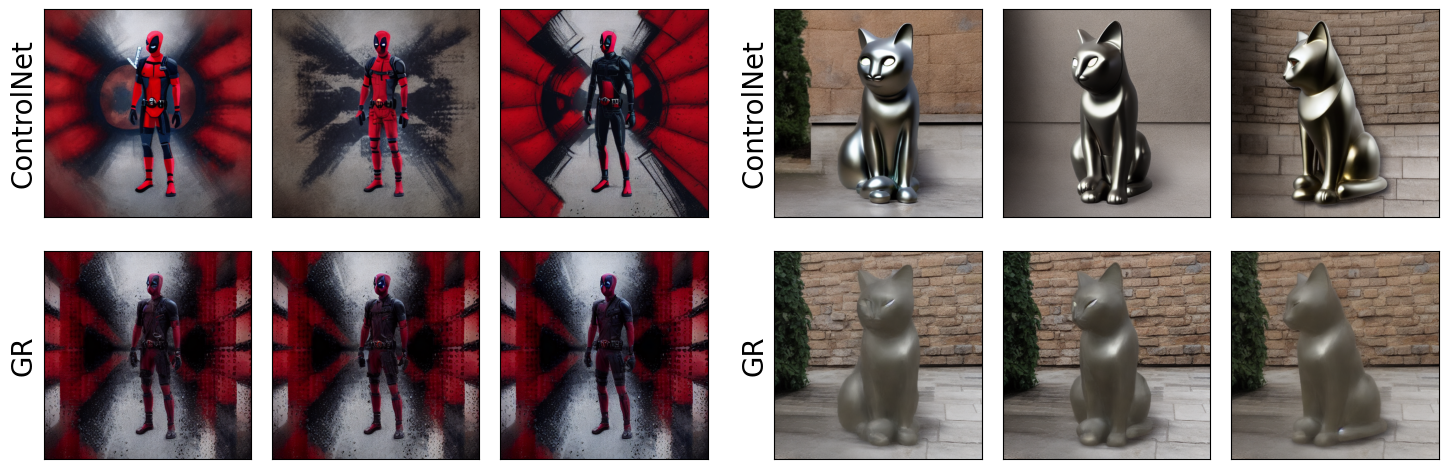

In [122]:
from text3d2video.utilities.matplotlib_utils import make_grid

scene_frame_indices = [[0, 1], [2, 3]]

# Let's say we want to extract a slice of length `w` from axis=-1 for each entry in dim=0
start_indices = [[0, 1], [2, 3]]  # one start index per entry along axis 0

# Slice accordingly
sliced = np.array([ims[i, :, start] for i, start in enumerate(start_indices)])
print(sliced.shape)


ims_cropped = sliced

fig, axs = make_grid(list(ims_cropped.shape), dim_labels={1: method_labels}, scale=3)

for idx, ax in np.ndenumerate(axs):
    ax.imshow(ims[idx])